# Generalized Cash Balance problem - One Step Ahead Optimization
## Scalability Implementation

In [1]:
import gurobipy as gb
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits import mplot3d
import pandas as pd
import time

The following simulation is applied to multiple cash and investment accounts and performance index is chosen such as to minimize current accounts balances - $w(0,1)$. $\\$
### $N = 2, M = 1$ 
In this specific implementation we use a uniform distribution with respect to the demand incurred by the accounts. $\\$
Parameters are chosen as follows:
- $x(0) = y(0) = 6$ as the initial balance;
- $ \alpha = 0.01$ as the interest rate on cash account;
- $ \beta = 0.04$ as the interest rate on investment account;
- $ \gamma = 0.02$ as the transaction cost;
- $ K_f = 30 $ as the discrete time-window;
- $ x_{min} = 1$ or $x_{max} = 2$;
- $ y_{min} = 0$

### Class for optimization with no intra current account transfers

In [2]:
#sc = gb.StatusConstClass
#status = {sc.__dict__[k]: k for k in sc.__dict__.keys() if k[0] >= 'A' and k[0] <= 'Z'}
class Model_2:
    
    a = 0.01 # interest on cash account
    b = 0.04 # interest on investment account
    c = 0.02 # tx fee

    def __init__(self,M,n,m,x_data,y_data,demand):
        self.M = M # # Const 50
        self.n = n # Number of cash accounts
        self.m = m # Number of investment accounts
        self.transfers = np.zeros((self.n,self.m)) #list of transfers for each cash account
        self.x_data = [*x_data] # Array of cash accounts balance
        self.y_data = [*y_data] # Array of investment accounts balance
        self.demand = [*demand] # Array of demands of each account

    def optim(self):

        self.transfers = np.zeros((self.n,self.m))

        osa = gb.Model()
        osa.modelSense = gb.GRB.MAXIMIZE
        osa.setParam('OutputFlag',0)
        osa.setParam("TimeLimit",3600)

        up = osa.addMVar(shape = (self.n,self.m), name = "up") # transfer positive
        un = osa.addMVar(shape = (self.n,self.m), name = "un") # negative transfer
        d_1 = osa.addMVar(shape = (self.n,self.m), name = "d_1", vtype = gb.GRB.BINARY)
        d_2 = osa.addMVar(shape = (self.n,self.m), name = "d_2", vtype = gb.GRB.BINARY)
        x = osa.addMVar(shape = self.n,name = "x") # Cash account constructor
        y = osa.addMVar(shape = self.m,name = "y") # Investment account constructor

        osa.addConstrs(up[i,j] <= self.M*d_1[i,j] for i in range(self.n) for j in range(self.m))
        osa.addConstrs(un[i,j] <= self.M*d_2[i,j] for i in range(self.n) for j in range(self.m))
        osa.addConstrs(d_1[i,j] + d_2[i,j] == 1 for i in range(self.n) for j in range(self.m))
          
        osa.addConstrs(1<=x[i] for i in range(self.n))
        osa.addConstrs(x[i]<=2 for i in range(self.n))      
        
        osa.addConstrs((1+self.a)*self.x_data[i] + gb.quicksum(up[i,:] - un[i,:]) -self.demand[i] -self.c*gb.quicksum(up[i,:] + un[i,:])
                         == x[i] for i in range(self.n))

        osa.addConstrs(0 <= y[j] for j in range(self.m))     
        osa.addConstrs((1+self.b)*self.y_data[j] - gb.quicksum(up[:,j] - un[:,j]) == y[j] for j in range(self.m))
        
        osa.setObjective(gb.quicksum([-x[i] for i in range(self.n)]))
        osa.optimize()

        self.transfers = up.x - un.x

        return self.transfers,x.x,y.x

        '''
        if osa.SolCount > 1:
            print("Solutions found")
        else:
            print("No feasible solution")
        '''

        #print(status[osa.status])

'\n        # Storing variables results\n        for i in range(self.n):\n            for j in range(self.m):\n                if up.x[i,j] == 0:\n                    self.u[i,j] = -un.x[i,j]\n                    # self.u.append(un.x[i,j])\n                else:\n                    self.u[i,j] = up.x[i,j]\n                    # self.u.append(up.x[i,j])\n            self.transfers[i] = np.sum(self.u[i,:])\n'

### Class for optimization with intra current account transfers

In [2]:
class Model_3:
    
    a = 0.01 # interest on cash account
    b = 0.04 # interest on investment account
    c = 0.02 # tx fee

    def __init__(self,M,n,m,x_data,y_data,demand):
        self.M = M # # Const 500
        self.n = n # Number of cash accounts
        self.m = m # Number of investment accounts
        self.transfers = np.zeros((self.n,self.m)) #list of transfers for each cash account
        self.x_data = [*x_data] # Array of cash accounts balance
        self.y_data = [*y_data] # Array of investment accounts balance
        self.demand = [*demand] # Array of demands of each account

    def optim(self):

        #self.transfers = np.zeros((self.n,self.m))

        osa = gb.Model()
        osa.modelSense = gb.GRB.MAXIMIZE
        osa.setParam('OutputFlag',0)
        osa.setParam("TimeLimit",3600)

        up = osa.addMVar(shape = (self.n,self.m), name = "up") # transfer positive
        un = osa.addMVar(shape = (self.n,self.m), name = "un") # negative transfer
        d_1 = osa.addMVar(shape = (self.n,self.m), name = "d_1", vtype = gb.GRB.BINARY)
        d_2 = osa.addMVar(shape = (self.n,self.m), name = "d_2", vtype = gb.GRB.BINARY)
        intra_transfers = osa.addMVar(shape = (self.n,self.n), name = "intra-transfers", lb = -gb.GRB.INFINITY) #intra-account transfers
        x = osa.addMVar(shape = self.n,name = "x") # Cash account constructor
        y = osa.addMVar(shape = self.m,name = "y") # Investment account constructor

        osa.addConstrs(up[i,j] <= self.M*d_1[i,j] for i in range(self.n) for j in range(self.m))
        osa.addConstrs(un[i,j] <= self.M*d_2[i,j] for i in range(self.n) for j in range(self.m))
        osa.addConstrs(d_1[i,j] + d_2[i,j] == 1 for i in range(self.n) for j in range(self.m))

        osa.addConstrs(intra_transfers[i,j]+intra_transfers[j,i] == 0 for i in range(self.n) for j in range(self.n))
          
        osa.addConstrs(1<=x[i] for i in range(self.n))
        osa.addConstrs(x[i]<=2 for i in range(self.n))      
        
        osa.addConstrs((1+self.a)*self.x_data[i] + gb.quicksum(up[i,:] - un[i,:]) -self.demand[i] -self.c*gb.quicksum(up[i,:] + un[i,:])
                        + gb.quicksum(intra_transfers[i,:]) == x[i] for i in range(self.n))

        osa.addConstrs(0 <= y[j] for j in range(self.m))     
        osa.addConstrs((1+self.b)*self.y_data[j] - gb.quicksum(up[:,j] - un[:,j]) == y[j] for j in range(self.m))
        
        osa.setObjective(gb.quicksum([-x[i] for i in range(self.n)]))
        osa.optimize()

        self.transfers = up.x - un.x

        return self.transfers,intra_transfers.x,x.x,y.x

### N = 2, M = 1 (without intra-account transfers)

In [4]:
n = 2
m = 1

In [5]:
# GENERATION OF RANDOM UNIFORM DEMAND
uniform_demand = np.ones([n,30])
for l in range(n):
    uniform_demand[l,:] = np.random.uniform(-1,1,30)

In [5]:

u_data = np.zeros((n,30))
x_data = np.ones((n,31))*6
y_data = np.ones((m,31))*6

#wealth = [0 for i in range(30)]

for i in range(1,31):

    data_cash = x_data[:,i-1]
    data_invest = y_data[:,i-1]

    model = Model_2(500,n,m,data_cash,data_invest,uniform_demand[:,i-1])

    u,cash,invest = model.optim()

    for j in range(n):

        u_data[j,i-1] = np.sum(u[j,:])
        x_data[j,i] = cash[j]

    for k in range(m):

        y_data[k,i] = invest[k]
    #wealth[i-1] = model.wealth_gain()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-02


### Plot of solutions of control variables

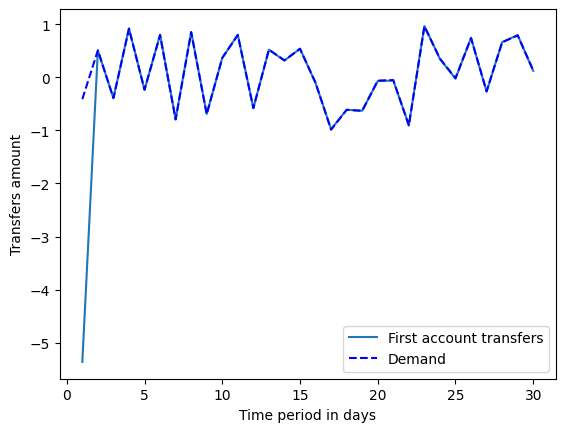

In [7]:

x = np.arange(1,31)

plt.plot(x,u_data[0,:])
plt.plot(x,uniform_demand[0,:],'b--')

plt.ylabel('Transfers amount')
plt.xlabel('Time period in days')
plt.legend(['First account transfers','Demand'])
plt.show()

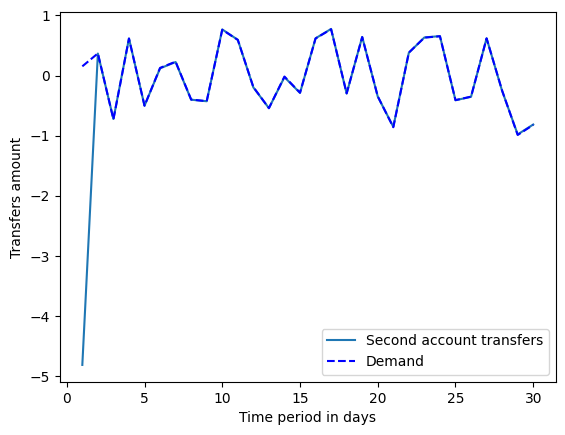

In [9]:
x = np.arange(1,31)

plt.plot(x,u_data[1,:])
plt.plot(x,uniform_demand[1,:],'b--')

plt.ylabel('Transfers amount')
plt.xlabel('Time period in days')
plt.legend(['Second account transfers','Demand'])
plt.show()

### Plot of solutions for cash accounts

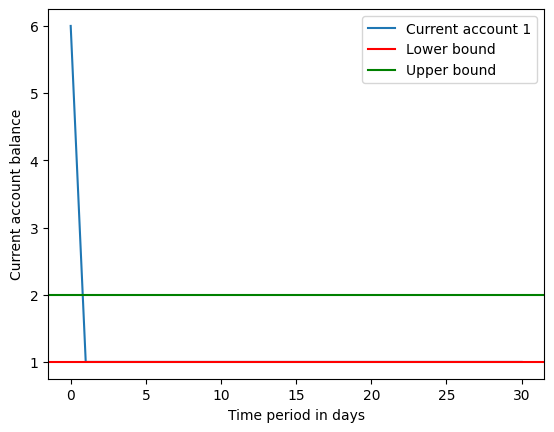

In [10]:
x = np.arange(0,31)

plt.plot(x,x_data[0,:])
plt.axhline(y = 1, color = 'r')
plt.axhline(y = 2, color = 'g')

plt.legend(['Current account 1', 'Lower bound', 'Upper bound'])

plt.ylabel('Current account balance')
plt.xlabel('Time period in days')

plt.show()

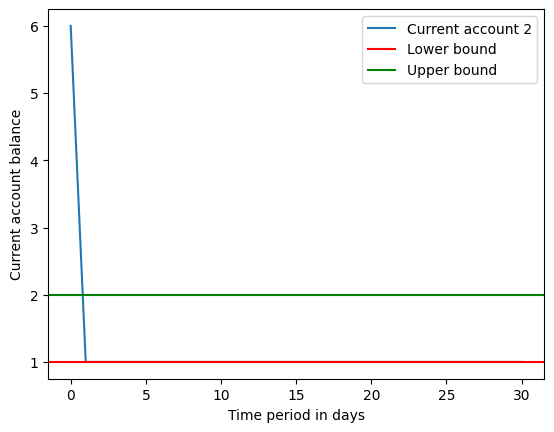

In [11]:
x = np.arange(0,31)

plt.plot(x,x_data[1,:])
plt.axhline(y = 1, color = 'r')
plt.axhline(y = 2, color = 'g')

plt.legend(['Current account 2', 'Lower bound', 'Upper bound'])

plt.ylabel('Current account balance')
plt.xlabel('Time period in days')

plt.show()

### N = 2, M = 1 (with intra-account transfers)

In [6]:
n = 2
m = 1

u_data = np.zeros((n,30))
x_data = np.ones((n,31))*6
y_data = np.ones((m,31))*6
intra_data = np.ones((n,30))

#wealth = [0 for i in range(30)]

for i in range(1,31):

    data_cash = x_data[:,i-1]
    data_invest = y_data[:,i-1]

    model = Model_3(500,n,m,data_cash,data_invest,uniform_demand[:,i-1])

    u,intra,cash,invest = model.optim()

    for j in range(n):

        u_data[j,i-1] = np.sum(u[j,:])
        x_data[j,i] = cash[j]
        intra_data[j,i-1] = np.sum(intra[j,:])

    for k in range(m):

        y_data[k,i] = invest[k]
    #wealth[i-1] = model.wealth_gain()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-02


[[-0.          4.22760003]
 [-4.22760003 -0.        ]]
[[-0.         -0.29978601]
 [ 0.29978601 -0.        ]]
[[-0.          0.00614062]
 [-0.00614062 -0.        ]]
[[-0.          0.72102543]
 [-0.72102543 -0.        ]]
[[-0.          0.91925474]
 [-0.91925474 -0.        ]]
[[-0.          0.13871793]
 [-0.13871793 -0.        ]]
[[-0.          0.48245607]
 [-0.48245607 -0.        ]]
[[-0.          0.09325288]
 [-0.09325288 -0.        ]]
[[-0.          0.91027744]
 [-0.91027744 -0.        ]]
[[-0.         -0.23191742]
 [ 0.23191742 -0.        ]]
[[-0.         -0.32885632]
 [ 0.32885632 -0.        ]]
[[-0.          0.39947891]
 [-0.39947891 -0.        ]]
[[-0.          0.96351344]
 [-0.96351344 -0.        ]]
[[-0.          0.80257185]
 [-0.80257185 -0.        ]]
[[-0.          0.93779673]
 [-0.93779673 -0.        ]]
[[-0.          0.64321782]
 [-0.64321782 -0.        ]]
[[-0.         -0.28732181]
 [ 0.28732181 -0.        ]]
[[-0.          0.92443513]
 [-0.92443513 -0.        ]]
[[-0.     

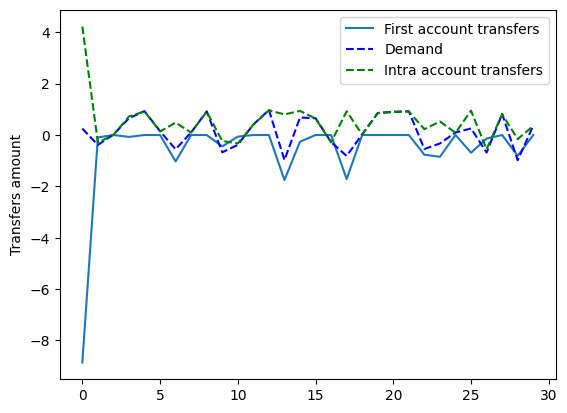

In [7]:
x = np.arange(0,30)

plt.plot(x,u_data[0,:])
plt.plot(x,uniform_demand[0,:],'b--')
plt.plot(x,intra_data[0,:], 'g--')

plt.ylabel('Transfers amount')
plt.legend(['First account transfers','Demand','Intra account transfers'])
plt.show()

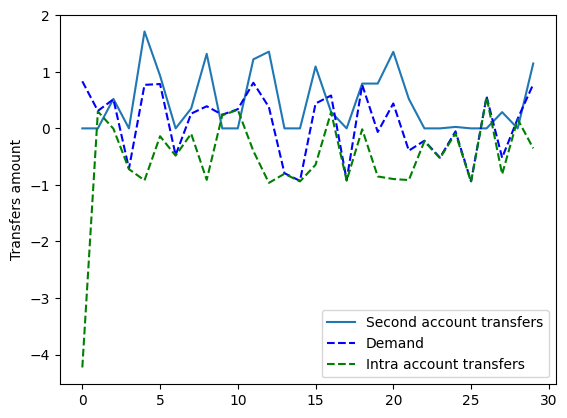

In [8]:
x = np.arange(0,30)

plt.plot(x,u_data[1,:])
plt.plot(x,uniform_demand[1,:],'b--')
plt.plot(x,intra_data[1,:], 'g--')

plt.ylabel('Transfers amount')
plt.legend(['Second account transfers','Demand','Intra account transfers'])
plt.show()

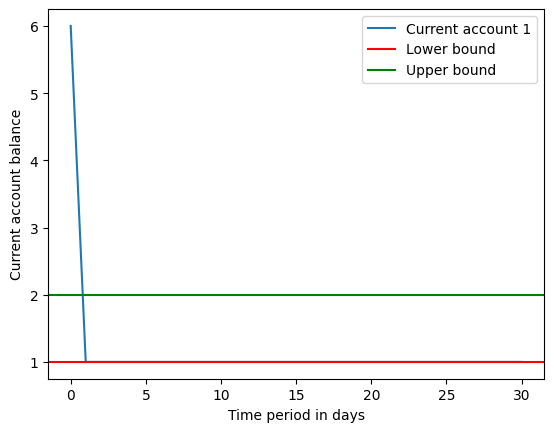

In [9]:
x = np.arange(0,31)

plt.plot(x,x_data[0,:])
plt.axhline(y = 1, color = 'r')
plt.axhline(y = 2, color = 'g')

plt.legend(['Current account 1', 'Lower bound', 'Upper bound'])

plt.ylabel('Current account balance')
plt.xlabel('Time period in days')

plt.show()

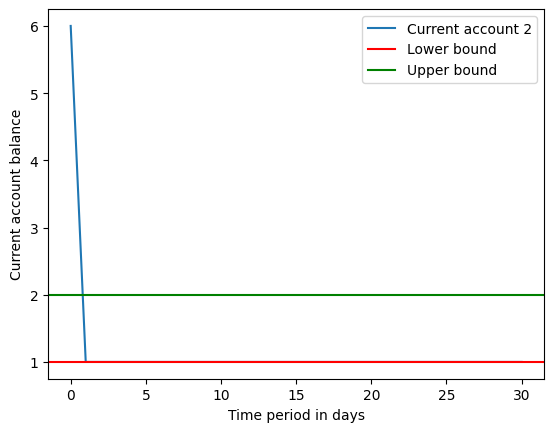

In [10]:
x = np.arange(0,31)

plt.plot(x,x_data[1,:])
plt.axhline(y = 1, color = 'r')
plt.axhline(y = 2, color = 'g')

plt.legend(['Current account 2', 'Lower bound', 'Upper bound'])

plt.ylabel('Current account balance')
plt.xlabel('Time period in days')

plt.show()

## Analysis of scalability
Each model considers a different number of accounts (incresing) and runs 10 times. Mean and variance of computational time over the runs are taken and compared. $\\$
Here we consider demand as a normal distribution. Also, parameters of interest rates over the accounts are taken from normal distributions with mean 2 and standard deviation 1, divided by 2000, 200, 4000 respectively for $\alpha, \beta,$ and $\gamma$ in order to consider more realistic values.

### M/N = 1/2

In [11]:
class Model_4:

    def __init__(self,M,n,m,x_data,y_data,demand,a,b,c):
        self.M = M # # Const 500
        self.n = n # Number of cash accounts
        self.m = m # Number of investment accounts
        self.transfers = np.zeros((self.n,self.m)) #list of transfers for each cash account
        self.x_data = [*x_data] # Array of cash accounts balance
        self.y_data = [*y_data] # Array of investment accounts balance
        self.demand = [*demand] # Array of demands of each account
        self.a = [*a]
        self.b = [*b]
        self.c = [*c]

    def optim(self):

        #self.transfers = np.zeros((self.n,self.m))

        osa = gb.Model()
        osa.modelSense = gb.GRB.MAXIMIZE
        osa.setParam('OutputFlag',0)
        osa.setParam("TimeLimit",3600)

        up = osa.addMVar(shape = (self.n,self.m), name = "up") # transfer positive
        un = osa.addMVar(shape = (self.n,self.m), name = "un") # negative transfer
        d_1 = osa.addMVar(shape = (self.n,self.m), name = "d_1", vtype = gb.GRB.BINARY)
        d_2 = osa.addMVar(shape = (self.n,self.m), name = "d_2", vtype = gb.GRB.BINARY)
        intra_transfers = osa.addMVar(shape = (self.n,self.n), name = "intra-transfers", lb = -gb.GRB.INFINITY) #intra-account transfers
        x = osa.addMVar(shape = self.n,name = "x") # Cash account constructor
        y = osa.addMVar(shape = self.m,name = "y") # Investment account constructor

        osa.addConstrs(up[i,j] <= self.M*d_1[i,j] for i in range(self.n) for j in range(self.m))
        osa.addConstrs(un[i,j] <= self.M*d_2[i,j] for i in range(self.n) for j in range(self.m))
        osa.addConstrs(d_1[i,j] + d_2[i,j] == 1 for i in range(self.n) for j in range(self.m))

        osa.addConstrs(intra_transfers[i,j]+intra_transfers[j,i] == 0 for i in range(self.n) for j in range(self.n))
          
        osa.addConstrs(1<=x[i] for i in range(self.n))
        osa.addConstrs(x[i]<=2 for i in range(self.n))      
        
        osa.addConstrs((1+self.a[i])*self.x_data[i] + gb.quicksum(up[i,:] - un[i,:]) -self.demand[i] -self.c[i]*gb.quicksum(up[i,:] + un[i,:])
                        + gb.quicksum(intra_transfers[i,:]) == x[i] for i in range(self.n))

        osa.addConstrs(0 <= y[j] for j in range(self.m))     
        osa.addConstrs((1+self.b[j])*self.y_data[j] - gb.quicksum(up[:,j] - un[:,j]) == y[j] for j in range(self.m))
        
        osa.setObjective(gb.quicksum([-x[i] for i in range(self.n)]))
        osa.optimize()

        self.transfers = up.x - un.x

        return self.transfers,intra_transfers.x,x.x,y.x

### N = 4, M = 2

In [23]:
values_t = [] # Initialize list of t values for one cash account

for l in range(10):
    n = 4
    m = 2

    u_data = np.zeros((n,30))
    x_data = np.ones((n,31))*10
    y_data = np.ones((m,31))*10
    intra_data = np.ones((n,30))

    a = abs(np.random.normal(2,1,n))/2000
    b = abs(np.random.normal(2,1,m))/200
    c = abs(np.random.normal(2,1,n))/4000 

    demand = np.ones([n,30])
    for w in range(n):
        demand[w,:] = np.random.normal(0,1,30)
    
    t = time.time()
    for i in range(1,31):
        
        data_cash = x_data[:,i-1]
        data_invest = y_data[:,i-1]

        model = Model_4(500,n,m,data_cash,data_invest,demand[:,i-1],a,b,c)

        u,intra,cash,invest = model.optim()

        for j in range(n):

            u_data[j,i-1] = np.sum(u[j,:])
            x_data[j,i] = cash[j]
            intra_data[j,i-1] = np.sum(intra[j,:])

        for k in range(m):

            y_data[k,i] = invest[k]
    
    t = time.time()-t
    values_t.append(t)


In [27]:
mean_t = np.mean(values_t) 
var_t = np.var(values_t)

In [28]:
print(mean_t,var_t)

3.8856332302093506 0.35031415357561857


### N = 10, M = 5

In [29]:
values_t1 = [] # Initialize list of t values for one cash account

for l in range(10):
    n = 10
    m = 5

    u_data = np.zeros((n,30))
    x_data = np.ones((n,31))*10
    y_data = np.ones((m,31))*10

    a = abs(np.random.normal(2,1,n))/2000
    b = abs(np.random.normal(2,1,m))/200
    c = abs(np.random.normal(2,1,n))/4000 

    demand = np.ones([n,30])
    for w in range(n):
        demand[w,:] = np.random.normal(0,1,30)
    
    t1 = time.time()
    for i in range(1,31):
        
        data_cash = x_data[:,i-1]
        data_invest = y_data[:,i-1]

        model = Model_4(500,n,m,data_cash,data_invest,demand[:,i-1],a,b,c)

        u,intra,cash,invest = model.optim()

        for j in range(n):

            u_data[j,i-1] = np.sum(u[j,:])
            x_data[j,i] = cash[j]

        for k in range(m):

            y_data[k,i] = invest[k]
    
    t1 = time.time()-t1
    values_t1.append(t1)

In [30]:
mean_t1 = np.mean(values_t1)
var_t1 = np.var(values_t1)

In [31]:
print(mean_t1,var_t1)

16.745595479011534 0.6563539548626233


### N = 20, M = 10

In [32]:
values_t2 = [] # Initialize list of t values for one cash account

for l in range(10):
    n = 20
    m = 10

    u_data = np.zeros((n,30))
    x_data = np.ones((n,31))*10
    y_data = np.ones((m,31))*10

    a = abs(np.random.normal(2,1,n))/2000
    b = abs(np.random.normal(2,1,m))/200
    c = abs(np.random.normal(2,1,n))/4000 

    demand = np.ones([n,30])
    for w in range(n):
        demand[w,:] = np.random.normal(0,1,30)
    
    t2 = time.time()
    for i in range(1,31):
        
        data_cash = x_data[:,i-1]
        data_invest = y_data[:,i-1]

        model = Model_4(500,n,m,data_cash,data_invest,demand[:,i-1],a,b,c)

        u,intra,cash,invest = model.optim()

        for j in range(n):

            u_data[j,i-1] = np.sum(u[j,:])
            x_data[j,i] = cash[j]

        for k in range(m):

            y_data[k,i] = invest[k]
    
    t2 = time.time()-t2
    values_t2.append(t2)

In [33]:
mean_t2 = np.mean(values_t2)
var_t2 = np.var(values_t2)

In [34]:
print(mean_t2,var_t2)

60.576433062553406 71.04975463299859


### N = 40, M = 20

In [35]:
values_t3 = [] # Initialize list of t values for one cash account

for l in range(10):
    n = 40
    m = 20

    u_data = np.zeros((n,30))
    x_data = np.ones((n,31))*10
    y_data = np.ones((m,31))*10

    a = abs(np.random.normal(2,1,n))/2000
    b = abs(np.random.normal(2,1,m))/200
    c = abs(np.random.normal(2,1,n))/4000 

    demand = np.ones([n,30])
    for w in range(n):
        demand[w,:] = np.random.normal(0,1,30)
    
    t3 = time.time()
    for i in range(1,31):
        
        data_cash = x_data[:,i-1]
        data_invest = y_data[:,i-1]

        model = Model_4(500,n,m,data_cash,data_invest,demand[:,i-1],a,b,c)

        u,intra,cash,invest = model.optim()

        for j in range(n):

            u_data[j,i-1] = np.sum(u[j,:])
            x_data[j,i] = cash[j]

        for k in range(m):

            y_data[k,i] = invest[k]
    
    t3 = time.time()-t3
    values_t3.append(t3)

In [36]:
mean_t3 = np.mean(values_t3)
var_t3 = np.var(values_t3)

In [37]:
print(mean_t3)
print(var_t3)

243.49635257720948
1270.3991971993876


### Table of values

In [38]:
scalability = pd.DataFrame({'Mean value of computational time':[mean_t,mean_t1,mean_t2,mean_t3],
                            'Variance of computational time':[var_t,var_t1,var_t2,var_t3]},
                            index = ('N=4, M=2','N=10, M=5','N=20, M=10', 'N=40, M=20'))

scalability

,Mean value of computational time,Variance of computational time
"N=4, M=2",3.885633,0.350314
"N=10, M=5",16.745595,0.656354
"N=20, M=10",60.576433,71.049755
"N=40, M=20",243.496353,1270.399197


### N increasing, M fixed

In [42]:
values_t4 = [] # Initialize list of t values for one cash account

n = 0
for l in range(10):
    n += 5
    m = 5

    u_data = np.zeros((n,30))
    x_data = np.ones((n,31))*10
    y_data = np.ones((m,31))*10

    a = abs(np.random.normal(2,1,n))/2000
    b = abs(np.random.normal(2,1,m))/200
    c = abs(np.random.normal(2,1,n))/4000 

    demand = np.ones([n,30])
    for w in range(n):
        demand[w,:] = np.random.normal(0,1,30)
    
    t4 = time.time()
    for i in range(1,31):
        
        data_cash = x_data[:,i-1]
        data_invest = y_data[:,i-1]

        model = Model_4(500,n,m,data_cash,data_invest,demand[:,i-1],a,b,c)

        u,intra,cash,invest = model.optim()

        for j in range(n):

            u_data[j,i-1] = np.sum(u[j,:])
            x_data[j,i] = cash[j]

        for k in range(m):

            y_data[k,i] = invest[k]
    
    t4 = time.time()-t4
    values_t4.append(t4)

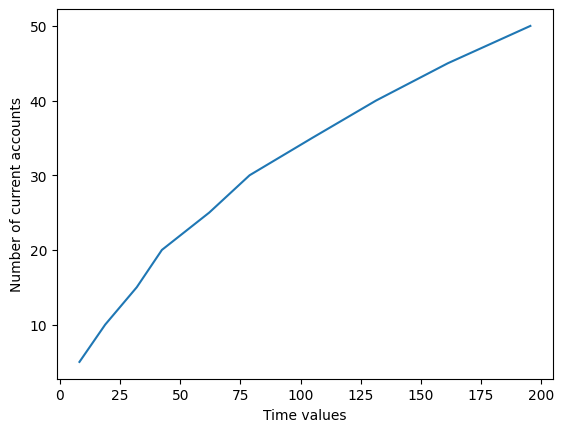

In [43]:
n1 = [5,10,15,20,25,30,35,40,45,50]

plt.plot(values_t4,n1)

plt.xlabel('Time values in seconds')
plt.ylabel('Number of current accounts')

plt.show()

### N fixed, M increasing

In [12]:
values_t5 = [] # Initialize list of t values for one cash account

m = 0
for l in range(10):
    n = 5
    m += 5

    u_data = np.zeros((n,30))
    x_data = np.ones((n,31))*10
    y_data = np.ones((m,31))*10

    a = abs(np.random.normal(2,1,n))/2000
    b = abs(np.random.normal(2,1,m))/200
    c = abs(np.random.normal(2,1,n))/4000 

    demand = np.ones([n,30])
    for w in range(n):
        demand[w,:] = np.random.normal(0,1,30)
    
    t5 = time.time()
    for i in range(1,31):
        
        data_cash = x_data[:,i-1]
        data_invest = y_data[:,i-1]

        model = Model_4(500,n,m,data_cash,data_invest,demand[:,i-1],a,b,c)

        u,intra,cash,invest = model.optim()

        for j in range(n):

            u_data[j,i-1] = np.sum(u[j,:])
            x_data[j,i] = cash[j]

        for k in range(m):

            y_data[k,i] = invest[k]
    
    t5 = time.time()-t5
    values_t5.append(t5)

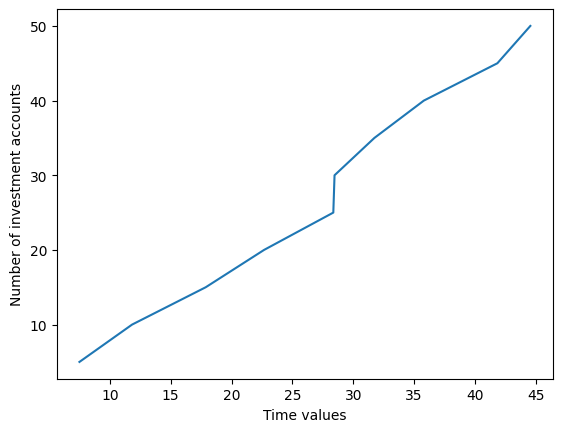

In [15]:
plt.plot(values_t5,n1)

plt.xlabel('Time values in seconds')
plt.ylabel('Number of investment accounts')

plt.show()